<div style="vertical-align:middle">
<img width="170" style="float: right;" src="https://www.upm.es/sfs/Rectorado/Gabinete%20del%20Rector/Logos/EU_Informatica/ETSI%20SIST_INFORM_COLOR.png" alt="ETSISI logo" />
<h1>Controladores PID y borroso para la ventilación en un refugio<a id="top"></a></h1>
<i><small>Fuentes: <a href="https://github.com/etsisi/Robotica">github.com/etsisi/Robotica</a><br>Última actualización: 2023-10-21</i>
</div>
<hr>

## Introducción

En el vasto campo de la ingeniería de control, donde se buscan soluciones para mantener sistemas en equilibrio y funcionando a niveles óptimos, los controladores PID destacan como una de las herramientas más versátiles y ampliamente utilizadas. PID, que significa Proporcional (**P**), Integral (**I**) y Derivativo (**D**), hace referencia a los tres componentes clave que trabajan conjuntamente para corregir el error entre un valor medido y el valor deseado o _set point_. Estos controladores son usados para el mantenimiento de una amplia variedad de sistemas como motores, termostatos y otras maquinarias.

### Objetivos

El propósito de este _notebook_ es proporcionar una breve introducción tutorial al control de lazo abierto y de lazo cerrado de un sistema simple de una sola entrada y una sola salida (SISO del inglés _Single In, Single Out_). Los objetivos a cubrir concretamente son:

1. **Entender los componentes básicos** de un controlador PID: Proporcional, Integral y Derivativo.
2. **Aprender cómo implementar** un controlador PID en Python.
3. **Visualizar el comportamiento** del controlador en un escenario realista.

Y no se nos ocurre un escenario más realista que el universo Fallout. ¡Comenzamos!

## Bibliotecas y configuración

Comenzaremos instalando las bibliotecas necesarias. Esto sólo es necesario en el caso de que no tengamos el entorno ya creado.

In [1]:
!pip install matplotlib
!pip install numpy


[notice] A new release of pip is available: 23.2.1 -> 23.3
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 23.3
[notice] To update, run: pip install --upgrade pip


A continuación importaremos las bibliotecas que se utilizarán a lo largo del notebook.

In [2]:
import random

import matplotlib.pyplot as plt
import numpy as np
from skfuzzy import control as ctrl

Forzamos algunos parámetros de configuración

In [3]:
random.seed(42)

%matplotlib inline
plt.style.use('ggplot')
plt.rcParams.update({'figure.figsize': (20, 6),'figure.dpi': 64})

***

## Descripción del problema

Dentro del complejo laberinto de pasadizos, estancias y sistemas que conforman el refugio, uno de los retos más significativos es asegurar la supervivencia de sus ocupantes en un mundo que ha sido drásticamente transformado por la guerra nuclear. Una preocupación principal es la calidad del aire dentro del refugio. En el exterior, las persistentes tormentas que asolan el planeta dispersan toxinas por todo el territorio conocido. Aunque el interior está protegido, no está completamente aislado de estos impactos. Después de todo, todos necesitamos respirar y el suministro de oxígeno no es infinito.

He sido nombrado el ingeniero principal del refugio, y se me ha encomendado la tarea crucial de asegurar que el nivel de oxígeno se mantenga en un rango estable, por ejemplo, un $80\%$. Un nivel excesivo de oxígeno es peligroso ya que el oxígeno es inflamable. Además, debemos facilitar una evolución artificial en nuestros cuerpos, ya que el dilema de la radiación no tiene una solución inmediata o a mediano plazo. Pero, por supuesto, un nivel insuficiente de oxígeno impedirá nuestra supervivencia, lo cual es contraproducente si nuestro objetivo es perseverar.

Para abordar esto de manera efectiva, implementaremos un controlador PID que monitoreará y ajustará los niveles de oxígeno y toxinas en el refugio. Cuando el controlador lo determine, se activarán los ventiladores permitiendo el ingreso de aire exterior para renovar el ambiente interior. Esperamos que, de esta manera, el nivel de oxígeno se mantenga estable, permitiéndonos enfocarnos en resolver otros problemas que enfrentamos.

In [4]:
TARGET_O2 = 80  # Porcentaje de O₂ objetivo

### Simulación del sistema a controlar

La clase `Vault` encapsula la representación de un refugio post-apocalíptico, diseñado para mantener un ambiente habitable en un mundo externo devastado. Esta clase se identifica por un ID único, y mantiene un seguimiento de los niveles de oxígeno y toxinas dentro del refugio. La metodología de la clase incluye funciones para medir la calidad del aire exterior, actualizar la ventilación en función de una señal de control, y obtener el estado actual de los niveles de oxígeno y toxinas dentro del refugio. La función measure simula la medición de la calidad del aire exterior generando un valor aleatorio, mientras que la función update ajusta los niveles internos de oxígeno y toxinas en función de la acción del ventilador, que es controlada por una señal de control externa. Por último, la función get_status proporciona una vista actual de los niveles de oxígeno y toxinas dentro del refugio. Esta estructura de clase proporciona una base sólida para simular y controlar el ambiente interno de un refugio en un escenario post-apocalíptico, permitiendo la interacción con controladores externos, como un controlador PID, para mantener condiciones habitables dentro del refugio.

In [5]:
class Vault:
    def __init__(self, id):
        self.id = id
        self.o2_level = 80.0  # Porcentaje de oxígeno en el interior

    def measure(self):
        """Simula la medición del ambiente externo.

        :return: Un valor de 0 a 100 indicando el nivel de oxigeno en el
            exterior
        """
        # Lo simulamos con un valor aleatorio de entre 0 y 100. Sí, el
        # ambiente exterior es muy peligroso
        return random.uniform(0, 100)

    def update(self, fan):
        """Simula el efecto de la ventilación.

        Si se activa el ventilador el oxígeno se renovará con una parte
        del oxígeno exterior. Si no, se simulará una degradación del
        ambiente interior.

        :param fan: Un valor numérico positivo si se ha de activar el
            ventilador o negativo si no.
        """
        if fan > 0:
            # Se activa el ventilador. Renovamos el aire del interior
            external_air_quality = self.measure()
            self.o2_level = min(self.o2_level + external_air_quality * 0.1, 100)
        else:
            # No se activa el ventilador. El ambiente se degrada
            self.o2_level = max(self.o2_level - 5, 0)

    def get_status(self):
        """Devuelve el estado actual de oxígeno."""
        return self.o2_level


## Control PID del sistema

La clase `PID` encapsula el controlador que intentará mantener el oxígeno dentro de un rango óptimo. Esta clase se usará para ajustar una variable de entrada, en este caso, la activación del ventilador, basándose en la diferencia entre el valor deseado y el valor actual de oxígeno, además de las tasas de cambio y acumulación de esta diferencia.

In [6]:
class PID:
    def __init__(self, kp=1, ki=0.1, kd=0.01):
        self.kp = kp
        self.ki = ki
        self.kd = kd
        self.prev_error = 0
        self.sum_error = 0

    def __call__(self, set_point, measured_value):
        error = set_point - measured_value
        self.sum_error += error
        d_error = error - self.prev_error
        output = self.kp * error + self.ki * self.sum_error + self.kd * d_error
        self.prev_error = error
        return output

Usaremos este controlador para mantener el refugio con el oxígeno establecido en la consigna indicada.

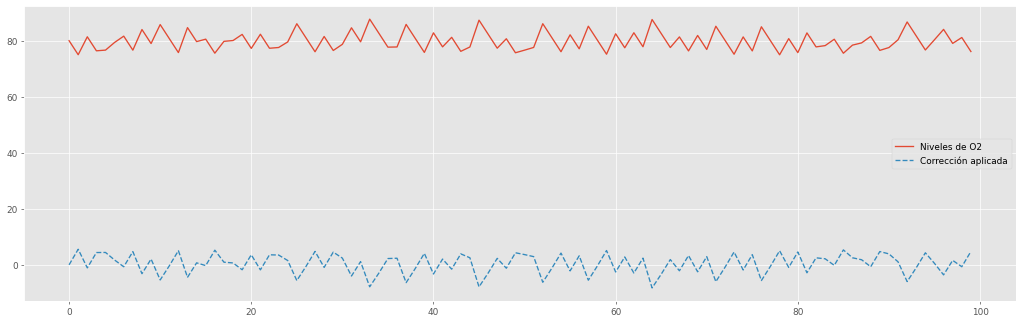

In [7]:
vault = Vault(101)
controller = PID(1.0, 0.1, 0.01)

o2_levels = []
actions = []
for i in range(100):  # 100 steps de tiempo
    o2_level = vault.get_status()
    action = controller(TARGET_O2, o2_level)
    vault.update(action)

    o2_levels.append(o2_level)
    actions.append(action)

plt.plot(o2_levels, label='Niveles de O2')
plt.plot(actions, label='Corrección aplicada', linestyle='--')
plt.legend()
plt.show()

## Control borroso del sistema

Ahora implementaremos la clase `FuzzyController` que describe el comportamiento de nuestro controlador en forma de reglas `IF-THEN`. La implementación, eso sí, es un poco más larga.

In [10]:
class FuzzyController:
    def __init__(self):
        # Definición de las variables lingüísticas de entrada y salida
        o2_error = ctrl.Antecedent(np.arange(-100, 101, 1), 'error')
        vent_level = ctrl.Consequent(np.arange(-100, 101, 1), 'vent')

        # Definición de las funciones de pertenencia (automático)
        o2_error.automf(3, names=['negative', 'none', 'positive'])
        vent_level.automf(3, names=['negative', 'none', 'positive'])

        # Definición de las reglas borrosas
        rules = [
            ctrl.Rule(o2_error['negative'], vent_level['positive']),
            ctrl.Rule(o2_error['none'], vent_level['none']),
            ctrl.Rule(o2_error['positive'], vent_level['negative']),
        ]

        # Creación del sistema de control borroso
        self.control = ctrl.ControlSystem(rules)
        self.sim = ctrl.ControlSystemSimulation(self.control)

    def __call__(self, set_point, measured_value):
        o2_error = measured_value - set_point
        
        # Asignación de las variables de entrada al sistema borroso
        self.sim.input['error'] = o2_error
        # Simulación del sistema de control borroso
        self.sim.compute()
        # Obtención del nivel de ventilación sugerido
        return self.sim.output['vent']

La aplicación en nuestro sistema a controlar sin embargo es similar. Veamos si ees capaz de mantenerlo en torno al nivel que hemos establecido como consigna:

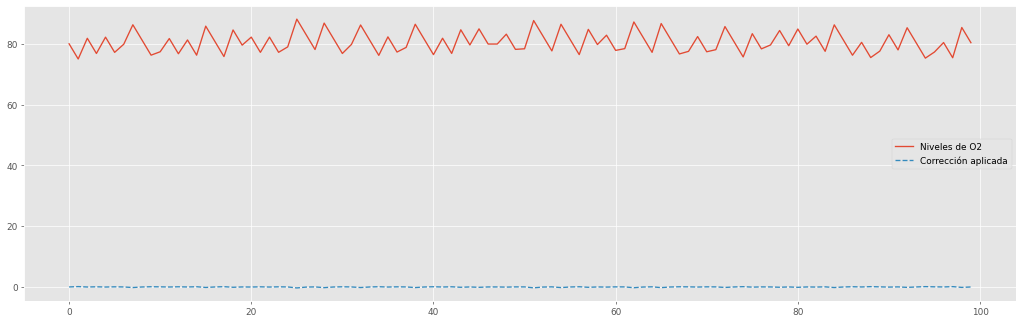

In [11]:
vault = Vault(101)
controller = FuzzyController()

o2_levels = []
actions = []
for i in range(100):  # 100 steps de tiempo
    o2_level = vault.get_status()
    action = controller(TARGET_O2, o2_level)
    vault.update(action)

    o2_levels.append(o2_level)
    actions.append(action)

plt.plot(o2_levels, label='Niveles de O2')
plt.plot(actions, label='Corrección aplicada', linestyle='--')
plt.legend()
plt.show()

## Conclusiones

A través de este ejercicio, hemos visto cómo implementar dos controladores, un PID y uno borroso. Los controladores PID, con su capacidad para responder y adaptarse a las variaciones y perturbaciones de un sistema, demuestran ser herramientas imprescindibles en muchos campos de la ingeniería. Los controladores borrosos también son herramientas poderosas con la ventaja de que son fácilmente entendibles y explicable, aunque computacionalmente (un poco más costoso. En nuestro ejemplo, la supervivencia de los habitantes del refugio dependía directamente de la eficacia del controlador. Aunque es una representación ficticia, subraya la relevancia y el impacto potencial de estas herramientas en situaciones críticas. Podemos destacar:

1. **Importancia del Control**: En un ambiente tan hostil y cambiante, tener herramientas que permitan un ajuste constante y preciso es vital. Los controladores PID y los basados en lógica borrosa emergen como una solución robusta para garantizar que variables críticas, como los niveles de radiación en el agua, permanezcan dentro de límites seguros.
2. **Dinámica de los Componentes PID**: Cada componente del PID tiene un papel fundamental en el comportamiento del controlador:
    - El componente Proporcional actúa directamente en función del error presente, proporcionando una respuesta inmediata.
    - El componente Integral asegura que los errores persistentes y acumulados se corrijan a lo largo del tiempo, evitando desviaciones sistemáticas.
    - El componente Derivativo anticipa el comportamiento futuro del error, contribuyendo a una corrección más suave y evitando oscilaciones.
4. **Manejo de Incertidumbre y No Linealidades**: Los controladores borrosos son especialmente útiles en sistemas con no linealidades severas o con incertidumbre en el modelo. Pueden manejar una amplia gama de situaciones sin requerir un modelo matemático preciso del sistema, lo que los hace más flexibles en entornos no lineales y cambiantes.
5. **Incorporación de Conocimiento de Expertos**: Los controladores borrosos permiten la incorporación directa del conocimiento de expertos a través de reglas borrosas. Esto puede ser ventajoso en sistemas donde el conocimiento empírico es valioso y no puede ser fácilmente representado con modelos matemáticos.
4. **Aplicabilidad Generalizada**: Aunque este ejemplo se centró en el escenario de Fallout, los principios subyacentes de los controladores PID son aplicables en una amplia variedad de situaciones y disciplinas, desde sistemas de climatización en edificios hasta regulación de velocidad en vehículos.
5. **Aprendizaje Continuo**: Es esencial entender que, si bien un controlador PID es potente, su eficacia depende en gran medida de su sintonización adecuada. La elección correcta de los parámetros $Kp$​, $Ki$​, y $Kd$​ puede variar según el sistema y las condiciones operativas. Experimentar y aprender de los resultados es una parte intrínseca de la ingeniería de control.

***

<div><img style="float: right; width: 120px; vertical-align:top" src="https://mirrors.creativecommons.org/presskit/buttons/88x31/png/by-nc-sa.png" alt="Creative Commons by-nc-sa logo" />

[Volver al inicio](#top)

</div>